In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import cf_units as cf
from ctsm_py import utils
import scipy
from scipy import signal,stats

In [1]:
from sklearn.linear_model import LinearRegression

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## Reading in data

In [4]:
# setting up the file path structure
dir = '/gpfs/fs1/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/'
run = 'clm50sp_clm50dev001_1deg_GSWP3V1_hist/'
proc = 'lnd/proc/tseries/month_1/'
pref = 'clm50sp_clm50dev001_1deg_GSWP3V1_hist.clm2.h0.'
suff = '.185001-201412.nc'

# plugging in the variable names
variables = ['FPSN','TWS']
pattern = dir+run+proc+pref+'{var}'+suff
files = [pattern.format(var=var) for var in variables]


In [5]:
# import files as xarray dataset

ds = utils.time_set_mid(xr.open_mfdataset(files,combine='by_coords', decode_times=True), 'time')
xf = 12*24*60*60/1e6     #umol/m2/s --> g/m2/d
ds.FPSN.values=ds.FPSN.values*xf
ds.FPSN.attrs['units']= 'gC/m2/d'


## Global annual mean GPP

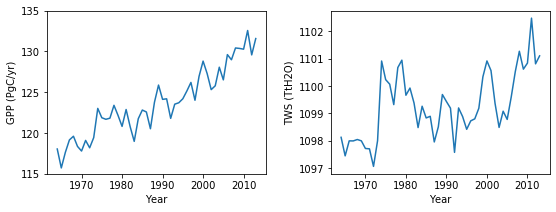

In [6]:
land_area = ds.area*ds.landfrac*1e6 #km2->m2
land_area.attrs['units']=cf.Unit('m^2')
ix_time = (ds['time.year']>1963)&(ds['time.year']<2014)
years = np.unique((ds['time.year'][ix_time]).values)

#  365 for d^-1 to yr^-1 ; 1e-15 for g to Pg
global_ann_gpp = 365*utils.weighted_annual_mean(land_area * ds.FPSN[ix_time,:,:]).sum(dim=('lat','lon'))*1e-15
global_ann_gpp.attrs['units']='PgC/yr'

#  1e-15 for kg ->Tt 
global_ann_tws = utils.weighted_annual_mean(land_area * ds.TWS[ix_time,:,:]).sum(dim=('lat','lon'))*1e-15
global_ann_gpp.attrs['units']='TtH2O/yr'

# sanity check
plt.figure(figsize=[9,3])

plt.subplot(121)
plt.plot(years,global_ann_gpp)
plt.ylim([115,135])
plt.yticks(np.linspace(115,135,5))
plt.xlabel('Year')
plt.ylabel('GPP (PgC/yr)')

plt.subplot(122)
plt.plot(years,global_ann_tws)
plt.xlabel('Year')
plt.ylabel('TWS (TtH2O)')

plt.subplots_adjust(wspace=0.3)



## Detrend data and fit linear model

In [50]:
global_ann_gpp_dt = signal.detrend(global_ann_gpp)
global_ann_tws_dt = signal.detrend(global_ann_tws)

model = LinearRegression().fit(global_ann_tws_dt.reshape((-1, 1)),global_ann_gpp_dt)

R = np.round(stats.pearsonr(global_ann_tws_dt,global_ann_gpp_dt)[0],2)
slope = np.round(model.coef_,2)[0]

## Plot

Text(0.5, 1.0, 'CLM5-SP')

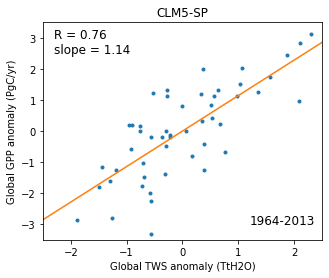

In [60]:
x = np.array([-2.5,2.5]).reshape(-1, 1)
y = model.predict(x)
fig = plt.figure(figsize=[5,4])
plt.plot(global_ann_tws_dt,global_ann_gpp_dt,'.')
plt.plot(x,y)
plt.xlim(-2.5,2.5)
plt.ylim(-3.5,3.5)
plt.text(-2.3,3,'R = '+str(R),fontsize=12)
plt.text(-2.3,2.5,'slope = '+str(slope),fontsize=12)
plt.text(1.2,-3,'1964-2013',fontsize=12)
plt.xlabel('Global TWS anomaly (TtH2O)')
plt.ylabel('Global GPP anomaly (PgC/yr)')
plt.title('CLM5-SP')

## Save Figure

In [61]:
fig.savefig('tws_gpp_global_clm5sp.pdf')

<Figure size 432x288 with 0 Axes>